In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import warnings 

In [28]:
df = pd.read_csv('../../../data/kc_house_data.csv')
df= df.dropna()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819


# Cleaning Data - mainly outliers 

- removing Null values
- handling placeholder values
- removing outliers
- dropping irrelevant columns (like id)

In [29]:
df=df.drop(['id'], axis=1)

In [30]:
df = df.drop([ 'sqft_above', 'date', 'sqft_living15', 'sqft_lot15'], axis=1)

In [31]:
df['sqft_basement'].describe()
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], errors='coerce')
mean_basement_no_outliers = df.loc[(df['sqft_basement'] != 4820) | (df['sqft_basement'] != 0), 'sqft_basement'].mean()
df['sqft_basement'] = np.where((df['sqft_basement'] == 4820) | (df['sqft_basement'] == 0), round(mean_basement_no_outliers), df['sqft_basement'])
df['sqft_lot'].describe()
mean_sqft_living_no_outliers = df.loc[(df['sqft_living'] != 13540) | (df['sqft_living'] != 370), 'sqft_living'].mean()
df['sqft_living'] = np.where((df['sqft_living'] == 13540) | (df['sqft_living'] == 370), round(mean_sqft_living_no_outliers), df['sqft_living'])
df['sqft_basement'].describe()
mean_sqft_lot_no_outliers = df.loc[(df['sqft_lot'] != 1.651359e+06) | (df['sqft_lot'] != 5.200000e+02), 'sqft_lot'].mean()
df['sqft_lot'] = np.where((df['sqft_lot'] == 1.651359e+06) | (df['sqft_lot'] == 5.200000e+02), round(mean_sqft_lot_no_outliers), df['sqft_lot'])
#cleaning outliers 

In [32]:
cleaned_df = df.replace(to_replace="?", value=np.NaN).dropna()

# Visualizing some of the data

<function matplotlib.pyplot.show(close=None, block=None)>

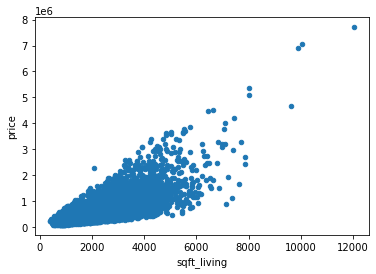

In [33]:
cleaned_df.plot(kind='scatter', x='sqft_living', y='price')
plt.show

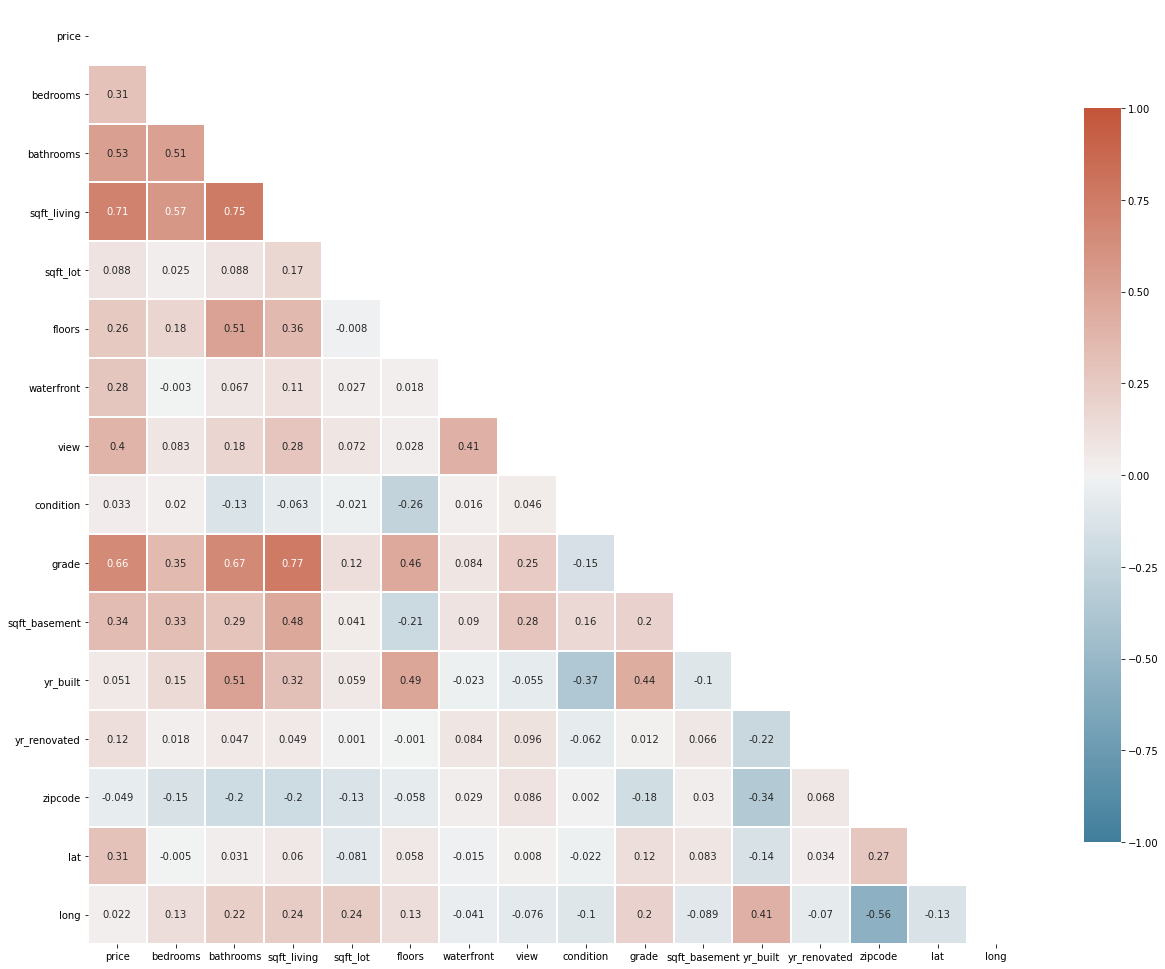

In [34]:
#checking for correlations - heat map
corr = round(cleaned_df.corr(), 3)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(21, 18))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .75}, annot=True)

In [35]:
cleaned_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,400.0,1951,1991.0,98125,47.7210,-122.319
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,910.0,1965,0.0,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,292.0,1987,0.0,98074,47.6168,-122.045
5,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,1530.0,2001,0.0,98053,47.6561,-122.005
8,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,730.0,1960,0.0,98146,47.5123,-122.337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,130.0,2008,0.0,98116,47.5773,-122.409
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,292.0,2009,0.0,98103,47.6993,-122.346
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,292.0,2014,0.0,98146,47.5107,-122.362
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,292.0,2009,0.0,98144,47.5944,-122.299


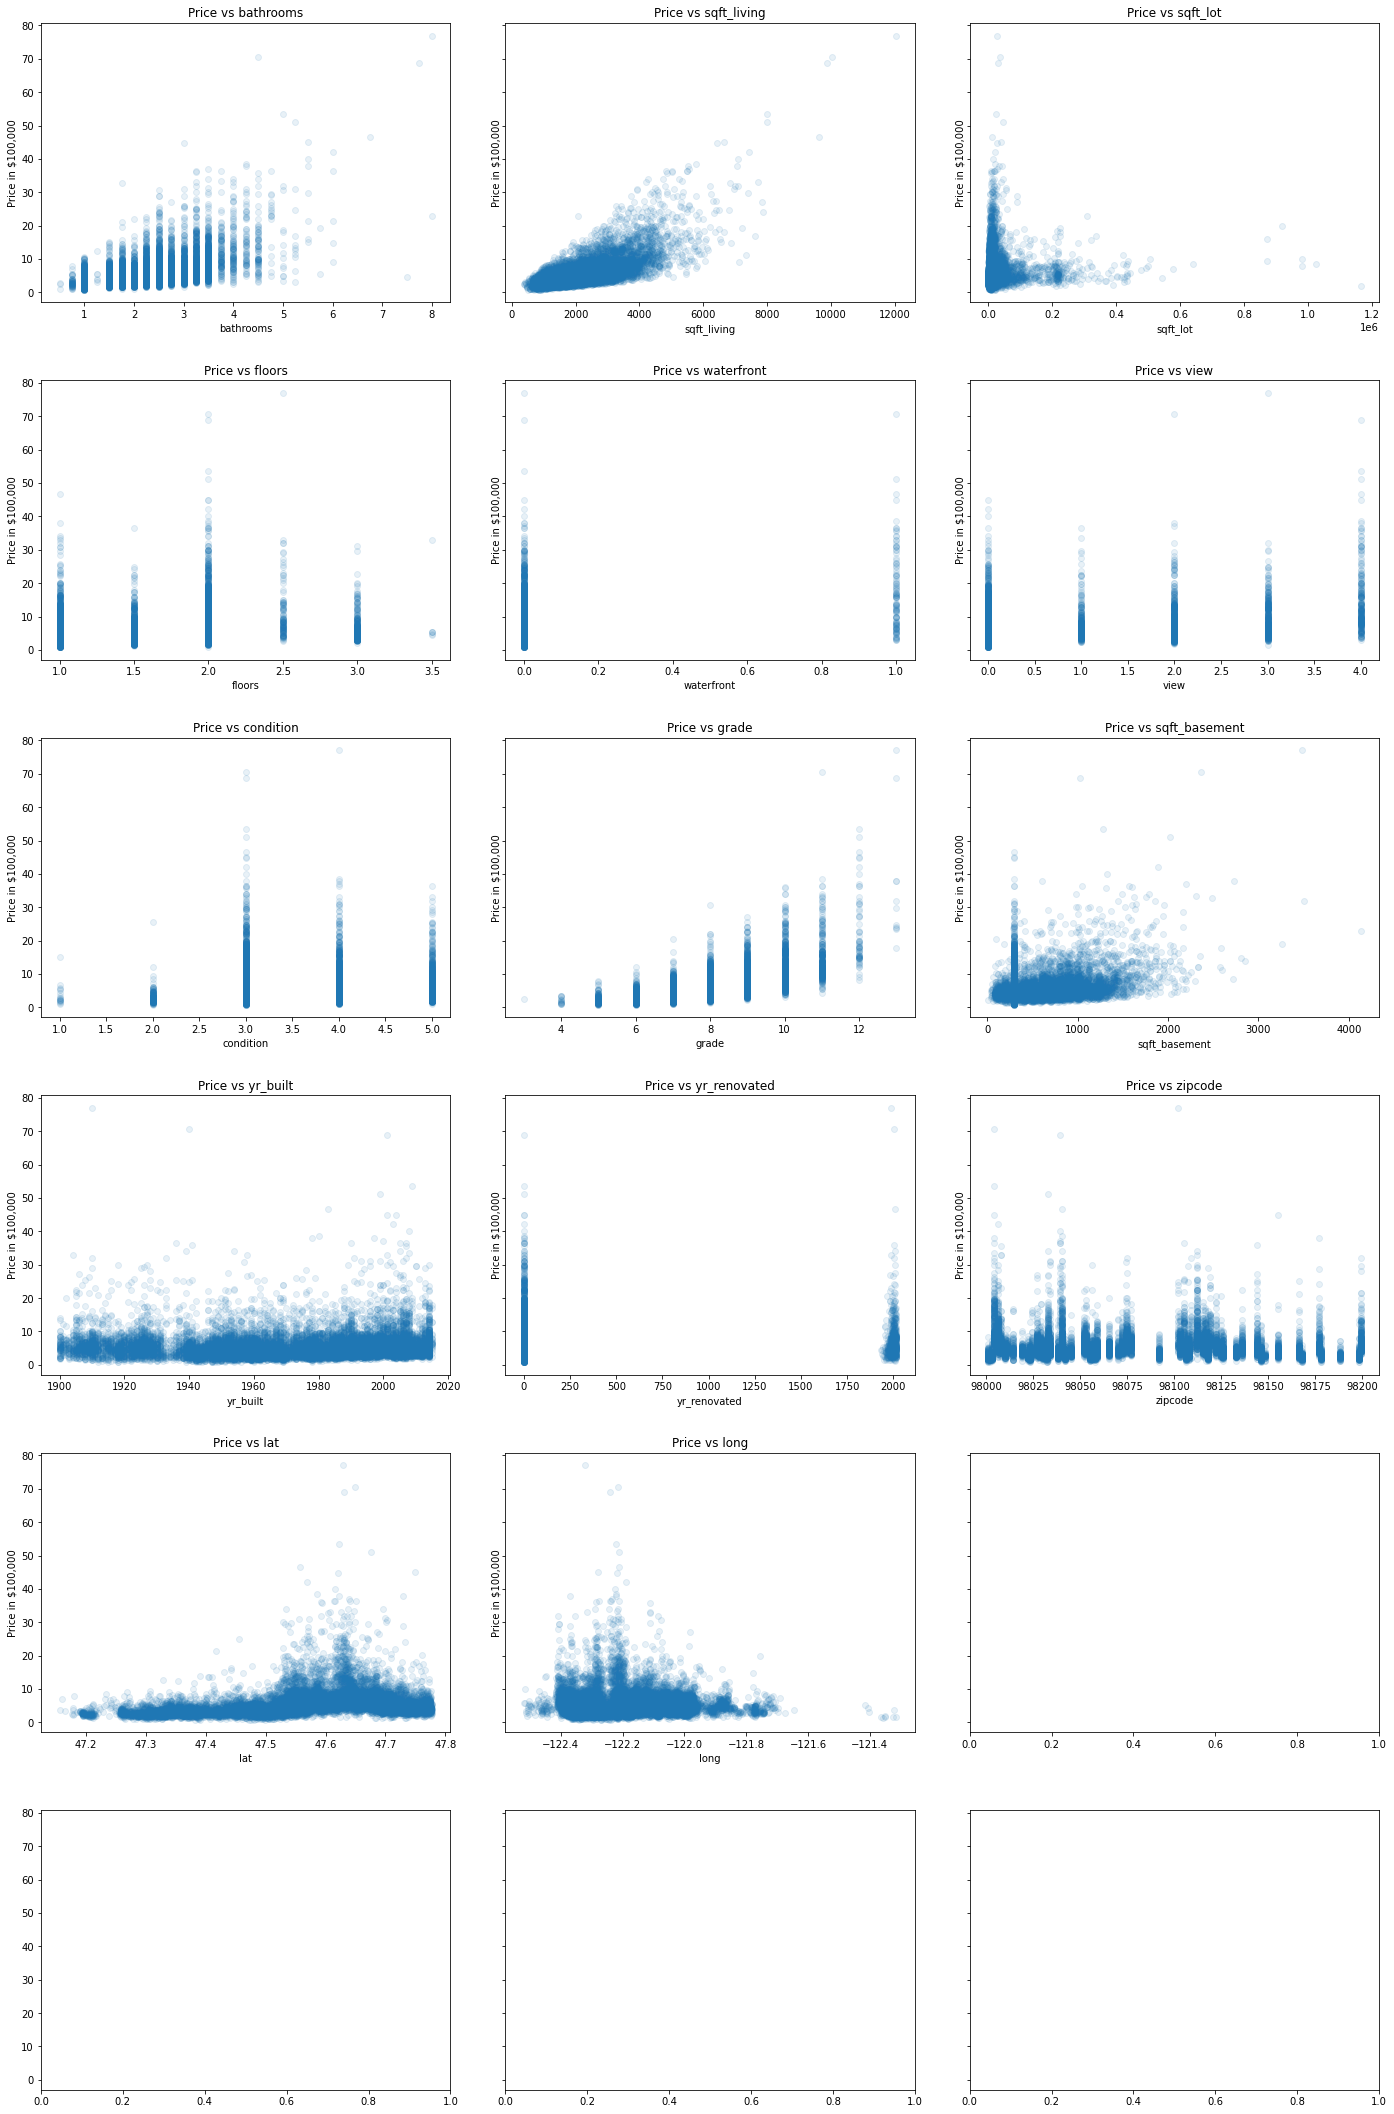

In [36]:
fig, axes = plt.subplots(6, 3, figsize=(20,30), sharey=True)
for ax, column in zip(axes.flatten(), cleaned_df.columns[2:]):
    ax.scatter(cleaned_df[column], cleaned_df['price'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price in $100,000')
fig.tight_layout(pad=3.0)

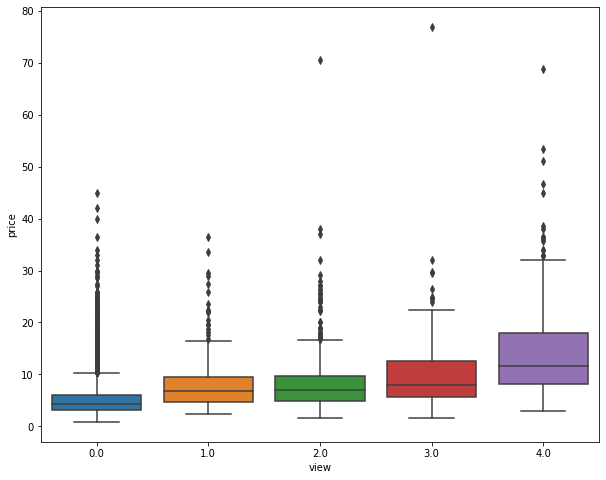

In [37]:
var = 'view'
data = pd.concat([cleaned_df['price'] / 100_000, cleaned_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x=var, y='price', data=data)

In [38]:
mean_no_view = cleaned_df.loc[(cleaned_df['view'] == 0), 'price'].mean()
mean_view = cleaned_df.loc[(cleaned_df['view'] != 0), 'price'].mean()
mean_view - mean_no_view
#difference between view and no view 
#we can conclude that view does influence the price of a home.

458232.17482101853

#### Plotting continous values - still visuals 

No handles with labels found to put in legend.


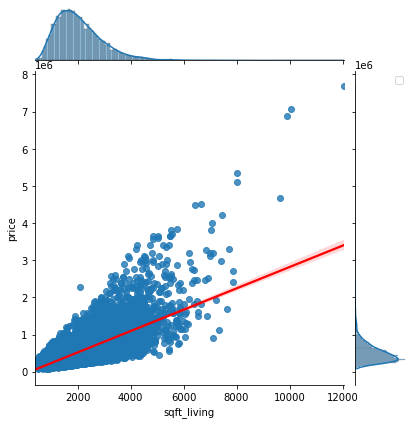

No handles with labels found to put in legend.


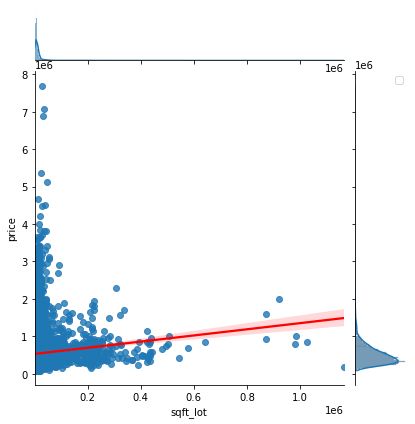

In [ ]:
continuous = ['sqft_living','sqft_lot','sqft_basement','yr_built']

for column in continuous:
    sns.jointplot(x=column, y="price", data=df, kind='reg', label=column,joint_kws={'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()

# Encoding categorical Features

In [ ]:
catagorical_df = ['bedrooms', 'bathrooms', 'grade']
encoded_df = pd.get_dummies(cleaned_df, columns = catagorical_df)

# Preprocessing

- Encoding
- Scaling Features
- Feature Engineering

In [ ]:
encoded_df['basement'] = np.where((encoded_df['sqft_basement'] != 0), 1, 0)
#feature eng. basementy boolean
#change df_dummy to encoded_df

In [ ]:
encoded_df['yes_view'] = np.where(encoded_df['view'] != 0, 1, 0)
#boolean column for view. Can be used as predictor 

In [ ]:
encoded_df = encoded_df.replace(to_replace="?", value=np.NaN).dropna()

# Model 

In [25]:
cleaned_df.shape

(15429, 16)

In [26]:
encoded_df.shape

NameError: name 'encoded_df' is not defined

## Baseline Model

In [60]:
# splitting up the target variable from the dataset
X = cleaned_df.drop(columns='price', axis=1)
y = cleaned_df['price']

In [61]:
# Split the dataset into train test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state =42)

In [62]:
regr = LinearRegression()
regr.fit(X_train, y_train)

# training score for baseline model
regr.score(X_train, y_train)

0.6933289366330107

In [63]:
# testing score for baseline model
regr.score(X_test, y_test)

0.7169617054678108

## Advanced Model

In [46]:
# splitting up the target variable from the dataset
X = encoded_df.drop(columns='price', axis=1)
y = encoded_df['price']

In [47]:
# Split the dataset into train test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state =42)

In [48]:
regr = LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

In [49]:
# y_pred = regr.predict(X_test)

regr.score(X_train, y_train)

0.7422631480716899

In [50]:
regr.score(X_test, y_test)

0.7365285827811558

In [ ]:
#fill zeros with mean value/no nan values 

In [ ]:
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training Root Mean Squared Error:' , train_rmse)
#~229k per house prediction

In [ ]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)

In [ ]:
coefficients

In [ ]:
test_preds = lm.predict(X_test)

In [ ]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, test_preds))
print(test_rmse )
#test set preformed better than train set 

In [ ]:
sns.residplot(y_test, test_preds, lowess=True, color='g');